This notebook shows the steps to build content-based recommendation system using the 10M Movielens dataset.

A content-based rec system is the simplest type of rec system, where a user is suggested movies (or items) that are most similar to the one's he/she has watched in the past. For example, I have watched a combination of action and comedy movies, it is recorded on my user profile and the rec system will recommend similar movies. This is illustrated below.

![content-based_rec.png](content-based_rec.png)

Source: Medium

#### MovieLens data sets were collected by the GroupLens Research Project at the University of Minnesota.

This data set contains 10000054 ratings and 95580 tags applied to 10681 movies by 71567 users of the online movie recommender service MovieLens.
    
URL: https://grouplens.org/datasets/movielens/100k/
Date of download: 30 Jul 2019

In [1]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


### Lets import all the datasets

The data are contained in three files, movies.dat, ratings.dat and tags.dat.

#### Movie genres in dataset

This dataset contains information about 10681 movies (items), 71567 users and 10M ratings. 

In [2]:
#List of genres
#movies_data = pd.read_csv('ml-10m/movies.dat',sep='|')
#u_genre.drop(labels='0',axis=1,inplace=True)
#u_genre.rename(index=str, columns={"unknown": "genre"},inplace=True)

cols = ['movie id', 'movie title' , '(no genres listed)', 'Action', 'Adventure',
'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western','IMAX']

genre_names = [ '(no genres listed)', 'Action', 'Adventure',
'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western','IMAX']

movies_df=pd.DataFrame()

with open('ml-10m/movies.dat','r', encoding="utf8") as f:
    for l in f:
        arr=[0]*len(genre_names)
        genres=l.rstrip('\n').split('::')[2].split('|')
        i=l.split('::')[0]
        title=l.split('::')[1]
        for g in genres:
            arr[genre_names.index(g)]=1
        
        #print(arr)
        arr.insert(0,title)
        arr.insert(0,i)
        movies_df=movies_df.append(pd.Series(arr),ignore_index=True)

In [3]:
def col_mapper(cols):
    return dict((cols.index(v), v) for v in cols)

col_map=col_mapper(cols)

In [4]:
#shape of movies dataframe
movies_df.shape
movies_df=movies_df.rename(columns=col_map)

#### Histogram of various genres in dataset

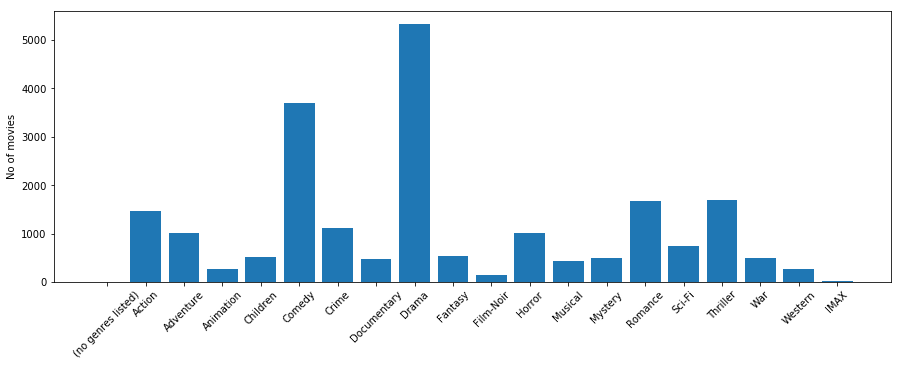

(no genres listed)       1.0
Action                1473.0
Adventure             1025.0
Animation              286.0
Children               528.0
Comedy                3703.0
Crime                 1118.0
Documentary            482.0
Drama                 5339.0
Fantasy                543.0
Film-Noir              148.0
Horror                1013.0
Musical                436.0
Mystery                509.0
Romance               1685.0
Sci-Fi                 754.0
Thriller              1706.0
War                    511.0
Western                275.0
IMAX                    29.0
dtype: float64


In [5]:
plt.figure(figsize=(15,5))
column_sum=movies_df.drop(labels=['movie id','movie title'],axis=1).sum(axis=0)
bins=(np.array(column_sum.keys()))
ypos=np.arange(len(bins))
plt.bar(ypos,column_sum.values,align='center', alpha=1)
plt.xticks(ypos, bins,rotation=45)
plt.ylabel('No of movies')
plt.show()
print(column_sum)

So while most of the genres are well represented, the drama and comedy genres most popular genres. We also have one movie that has no genres listed, which we will remove since they do not help us in the recomendation system. 

In [7]:
movies_df.drop(movies_df.index[movies_df['(no genres listed)']==1],axis=0,inplace=True)

### Building the content-based rec system

#### Items feature dataframe
We don't need the movie title, release data, video release date and IMDB url columns in the Items dataframe, so we'll drop them

In [8]:
item_features=movies_df.drop(labels=['movie id','movie title','(no genres listed)'],axis=1)
item_features.head(6)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX
0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Cleaning the data
It is important for all the movies to be assigned to a genre. If not, we have to remove them. We can check this by calculating a row-wise sum for all movies, which has to >1 if it has an assigned genre 

In [9]:
#calculate sum of all rows and normalize each cateogy for each item
row_sum=item_features.sum(axis=1)
row_sum[row_sum==0]

Series([], dtype: float64)

#### TF-IDF Normalization
The dataset contains 505 comedy and 725 drama movies, out of a total of 1682 movies in the dataset. These two genres would dominate the recommendations even if there are other genres associated with a particular movie which is equally important. Therefore there needs to a be normalization of some kind. 
Here I use tf-idf methodology to normalize the generes of movies, as typically done in text document analysis. 

_ tf (term frequency) = n/N _

_ idf (inverse document frequency) = log (1/tf) _


IDF is calculated by taking the logarithmic inverse of the document frequency among the whole corpus of documents. So, if there are a total of n mivies and amongst those movies, ‘animation’ appears in x of them, it’s IDF score will be: Log10 (n/x)



In [10]:
#calculate TF and IDF for each feature for the items
column_sum=item_features.sum(axis=0)
tf=column_sum/len(item_features)

IDF=np.log10(1/tf)
print(IDF)

Action         0.860369
Adventure      1.017847
Animation      1.572205
Children       1.305937
Comedy         0.460018
Crime          0.980129
Documentary    1.345524
Drama          0.301111
Fantasy        1.293771
Film-Noir      1.858310
Horror         1.022962
Musical        1.389085
Mystery        1.321853
Romance        0.801971
Sci-Fi         1.151200
Thriller       0.796592
War            1.320150
Western        1.589239
IMAX           2.566173
dtype: float64


From the above caculations, we observe that the DF for drama and comedy are the highest as also previously observed in the bar plot. The IDF values are invesely related to DF, so drama and comedy will show the lowest IDF values. This allows us to counter the bias in recommendations, without which the genre 'Drama' or 'Comedy' would be assigned higher weights just because of their high frequency in the dataset.   

#### The dot product of movie feature vectors and IDF vectors gives us the weighted attribute scores of each movie

The movie feature vectors can then be multiplied by idf vector to obtain the new feature vectors that is normalized by corpus of movies.  

As seen below in the case of movie id 1, Animation, Children's and Comedy have decreasing weighted scores. This is becasue there are only 42 Animation movies compared to 122 and 505 Children's and Comedy movies respectively. Hence, the Animation genre gets a higher rating. 

In [11]:
#lets calculate weighted score of features for each item by taking dot product of feature vector for each item with the IDF vector
item_features=item_features.multiply(IDF,axis=1)
print("For the movie:",movies_df.iloc[0]['movie title'])
item_features.iloc[0]

For the movie: Toy Story (1995)


Action         0.000000
Adventure      1.017847
Animation      1.572205
Children       1.305937
Comedy         0.460018
Crime          0.000000
Documentary    0.000000
Drama          0.000000
Fantasy        1.293771
Film-Noir      0.000000
Horror         0.000000
Musical        0.000000
Mystery        0.000000
Romance        0.000000
Sci-Fi         0.000000
Thriller       0.000000
War            0.000000
Western        0.000000
IMAX           0.000000
Name: 0, dtype: float64

### Find movies similar to a given movies
For finding movies similar to other movies in the dataset, we first extract the targe features for the given movie and 
then find similarities with other movies by computing dot product between the weighted scores for each movie pair.

For examples, lets consider the key words "Star Wars"

In [12]:
movie_liked='Forrest Gump'

#find movies called Toy Story in items dataframe
movie_id_liked=movies_df[movies_df['movie title'].str.contains(movie_liked)].index.values

if len(movie_id_liked)==0:
    print('movie not found. please try again..')

print("Target movie id: ",movie_id_liked)
print("Target movies: ")
print([movies_df.loc[i]['movie title'] for i in movie_id_liked])

target_features=item_features.loc[movie_id_liked[0]]
print("Target movie features: \n",target_features)


Target movie id:  [352]
Target movies: 
['Forrest Gump (1994)']
Target movie features: 
 Action         0.000000
Adventure      0.000000
Animation      0.000000
Children       0.000000
Comedy         0.460018
Crime          0.000000
Documentary    0.000000
Drama          0.301111
Fantasy        0.000000
Film-Noir      0.000000
Horror         0.000000
Musical        0.000000
Mystery        0.000000
Romance        0.801971
Sci-Fi         0.000000
Thriller       0.000000
War            1.320150
Western        0.000000
IMAX           0.000000
Name: 352, dtype: float64


Calculate cosine similarities with all other movies in the dataset to obtian a vector of length 1680 (number of movies in the dataset)

In [13]:
target_features=target_features.reshape(1, -1)
cosine_sim=cosine_similarity(item_features,target_features)
print(cosine_sim.shape)

(10680, 1)


C:\Users\Sangy\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


In [14]:
cosine_sim=cosine_sim.flatten()
results_df=pd.DataFrame(cosine_sim,list(item_features.index.values))

suggested=results_df.sort_values(by=0,ascending=False).index.values

for i in  suggested[:5000]:
    print(i,' ',movies_df.loc[i]['movie title']," | Score:", results_df[0][i])

9635   Tiger and the Snow, The (La Tigre e la neve) (2005)  | Score: 1.0
3900   Malèna (2000)  | Score: 1.0
2240   Life Is Beautiful (La Vita è bella) (1997)  | Score: 1.0
9313   Life is a Miracle (Zivot je cudo) (2004)  | Score: 1.0
10089   I Served the King of England (Obsluhoval jsem anglického krále) (2006)  | Score: 1.0
352   Forrest Gump (1994)  | Score: 1.0
2918   Train of Life (Train De Vie) (1998)  | Score: 1.0
5917   Divine Intervention (Yadon ilaheyya) (2002)  | Score: 1.0
7854   Terminal, The (2004)  | Score: 1.0
4701   Father Goose (1964)  | Score: 0.982991522589
7100   Kiss Them for Me (1957)  | Score: 0.982991522589
8543   To Be Or Not To Be (1983)  | Score: 0.982991522589
9042   Waterloo Bridge (1940)  | Score: 0.959833716024
5277   Cranes Are Flying, The (Letyat zhuravli) (1957)  | Score: 0.959833716024
5272   Ballad of a Soldier (Ballada o soldate) (1959)  | Score: 0.959833716024
3763   Aimée & Jaguar (1999)  | Score: 0.959833716024
8987   Yanks (1979)  | Score: 0.959

4864   Behind Enemy Lines (2001)  | Score: 0.697043362032
108   Braveheart (1995)  | Score: 0.697043362032
7866   Flying Leathernecks, The (1951)  | Score: 0.697043362032
1182   Apocalypse Now (1979)  | Score: 0.697043362032
4732   Big Red One, The (1980)  | Score: 0.697043362032
7972   Enemy Below, The (1957)  | Score: 0.697043362032
8582   Bullet in the Head (1990)  | Score: 0.697043362032
7581   Bridge Too Far, A (1977)  | Score: 0.697043362032
2859   Dirty Dozen, The (1967)  | Score: 0.697043362032
7468   To Hell and Back (1955)  | Score: 0.697043362032
7443   Alexander Nevsky (Aleksandr Nevskiy) (1938)  | Score: 0.697043362032
9319   Jarhead (2005)  | Score: 0.697043362032
10043   Beaufort (2007)  | Score: 0.697043362032
7126   King David (1985)  | Score: 0.697043362032
9191   Great Raid, The (2005)  | Score: 0.697043362032
5324   Windtalkers (2002)  | Score: 0.697043362032
9036   Battle of the Bulge (1965)  | Score: 0.697043362032
8969   Green Berets, The (1968)  | Score: 0.69704

8344   Atalante, L' (1934)  | Score: 0.593039393031
3176   Singles (1992)  | Score: 0.593039393031
6243   101 Reykjavik (101 Reykjavík) (2000)  | Score: 0.593039393031
368   Reality Bites (1994)  | Score: 0.593039393031
6241   Trip, The (2002)  | Score: 0.593039393031
9680   Shortbus (2006)  | Score: 0.593039393031
10   American President, The (1995)  | Score: 0.593039393031
9842   Avenue Montaigne (Fauteuils d'orchestre) (2006)  | Score: 0.593039393031
3990   Barfly (1987)  | Score: 0.593039393031
6167   Raising Victor Vargas (2002)  | Score: 0.593039393031
9699   Good Year, A (2006)  | Score: 0.593039393031
6165   What a Girl Wants (2003)  | Score: 0.593039393031
9830   I Think I Love My Wife (2007)  | Score: 0.593039393031
9948   Broken English (2007)  | Score: 0.593039393031
6381   Alex and Emma (2003)  | Score: 0.593039393031
9985   Nanny Diaries, The (2007)  | Score: 0.593039393031
6600   Luster (2002)  | Score: 0.593039393031
4992   Get Out Your Handkerchiefs (Préparez vos mouch

1278   When Harry Met Sally... (1989)  | Score: 0.563886562323
5182   Fraternity Vacation (1985)  | Score: 0.563886562323
3659   Match, The (1999)  | Score: 0.563886562323
5081   Luminarias (2000)  | Score: 0.563886562323
4194   Paris When It Sizzles (1964)  | Score: 0.563886562323
4192   Frankie and Johnny (1991)  | Score: 0.563886562323
5126   Kissing Jessica Stein (2001)  | Score: 0.563886562323
5145   Seems Like Old Times (1980)  | Score: 0.563886562323
2340   You've Got Mail (1998)  | Score: 0.563886562323
5178   Bar Girls (1994)  | Score: 0.563886562323
7370   Midnight (1939)  | Score: 0.563886562323
7362   Love Life (2001)  | Score: 0.563886562323
7353   100 Girls (2000)  | Score: 0.563886562323
1520   When the Cat's Away (Chacun cherche son chat) (1996)  | Score: 0.563886562323
1500   Trial and Error (1997)  | Score: 0.563886562323
7141   Win a Date with Tad Hamilton! (2004)  | Score: 0.563886562323
7139   It (1927)  | Score: 0.563886562323
5433   Serving Sara (2002)  | Score: 

1762   Live Flesh (Carne trémula) (1997)  | Score: 0.522471515112
9281   Brokeback Mountain (2005)  | Score: 0.522471515112
7025   In America (2002)  | Score: 0.522471515112
7028   Honey (2003)  | Score: 0.522471515112
530   Shadowlands (1993)  | Score: 0.522471515112
7034   Love Don't Cost a Thing (2003)  | Score: 0.522471515112
9279   Separate Lies (2005)  | Score: 0.522471515112
9454   Ask the Dust (2006)  | Score: 0.522471515112
6556   Road Home, The (Wo de fu qin mu qin) (1999)  | Score: 0.522471515112
7037   Girl with a Pearl Earring (2003)  | Score: 0.522471515112
1767   I Love You, Don't Touch Me! (1998)  | Score: 0.522471515112
1768   Leather Jacket Love Story (1997)  | Score: 0.522471515112
3895   Bounce (2000)  | Score: 0.522471515112
2884   Man and a Woman, A (Un Homme et une Femme) (1966)  | Score: 0.522471515112
676   Country Life (1994)  | Score: 0.522471515112
3886   Legend of Bagger Vance, The (2000)  | Score: 0.522471515112
1645   Good Will Hunting (1997)  | Score: 0.

8779   3-Iron (Bin-jip) (2004)  | Score: 0.522471515112
6894   Last Tango in Paris (Ultimo tango a Parigi) (1972)  | Score: 0.522471515112
8698   Springtime in a Small Town (Xiao cheng zhi chun) (2002)  | Score: 0.522471515112
5250   Wild Orchid (1990)  | Score: 0.522471515112
8750   Fond Kiss, A (Ae Fond Kiss...) (2004)  | Score: 0.522471515112
7809   Heiress, The (1949)  | Score: 0.522471515112
7823   Samsara (2001)  | Score: 0.522471515112
5269   Lady and the Duke, The (L'Anglaise et le Duc) (2001)  | Score: 0.522471515112
5271   My Beautiful Laundrette (1985)  | Score: 0.522471515112
8715   Facing Windows (La Finestra di fronte) (2003)  | Score: 0.522471515112
5308   84 Charing Cross Road (1987)  | Score: 0.522471515112
8714   Twilight Samurai, The (Tasogare Seibei) (2002)  | Score: 0.522471515112
3618   Nine 1/2 Weeks (1986)  | Score: 0.522471515112
7832   Panic in the Needle Park, The (1971)  | Score: 0.522471515112
4153   Shadow Magic (2000)  | Score: 0.522471515112
219   Circle

216   Boys on the Side (1995)  | Score: 0.335331036591
7782   Wish You Were Here (1987)  | Score: 0.335331036591
5365   Me Without You (2001)  | Score: 0.335331036591
5359   Object of Beauty, The (1991)  | Score: 0.335331036591
8759   Schultze Gets the Blues (2003)  | Score: 0.335331036591
10106   Savages, The (2007)  | Score: 0.335331036591
10116   Go-Getter, The (2007)  | Score: 0.335331036591
5357   Lost in Yonkers (1993)  | Score: 0.335331036591
2764   Queens Logic (1991)  | Score: 0.335331036591
2206   Stardust Memories (1980)  | Score: 0.335331036591
10121   Big Bad Swim, The (2006)  | Score: 0.335331036591
4135   Brothers, The (2001)  | Score: 0.335331036591
2760   Whiteboyz (1999)  | Score: 0.335331036591
8775   Goodbye, Dragon Inn (Bu san) (2003)  | Score: 0.335331036591
3047   Daddy Long Legs (1919)  | Score: 0.335331036591
8804   Little Miss Marker (1980)  | Score: 0.335331036591
3278   American Graffiti (1973)  | Score: 0.335331036591
8839   Milky Way, The (Voie lactée, La)

2876   Story of Us, The (1999)  | Score: 0.335331036591
1411   Kolya (Kolja) (1996)  | Score: 0.335331036591
6105   Mr. North (1988)  | Score: 0.335331036591
9093   Ugly, Dirty and Bad (Brutti sporchi e cattivi) (1976)  | Score: 0.335331036591
9094   Léolo (1992)  | Score: 0.335331036591
1755   Last Days of Disco, The (1998)  | Score: 0.335331036591
6582   Suddenly (Tan de Repente) (2002)  | Score: 0.335331036591
6576   Autumn Spring (Babí léto) (2001)  | Score: 0.335331036591
9103   Simon (2004)  | Score: 0.335331036591
7300   Going in Style (1979)  | Score: 0.335331036591
611   Flower of My Secret, The (La Flor de Mi Secreto) (1995)  | Score: 0.335331036591
9290   C.S.A.: The Confederate States of America (2004)  | Score: 0.335331036591
3821   Beautiful (2000)  | Score: 0.335331036591
9111   Longest Yard, The (2005)  | Score: 0.335331036591
3920   Punchline (1988)  | Score: 0.335331036591
9277   Squid and the Whale, The (2005)  | Score: 0.335331036591
9274   In Her Shoes (2005)  | Sc

3509   Hamlet (2000)  | Score: 0.293272140338
3711   Criminal Lovers (Les Amants Criminels) (1999)  | Score: 0.293272140338
2679   Thomas Crown Affair, The (1968)  | Score: 0.293272140338
290   Léon: The Professional (Léon) (Professional, The) (1994)  | Score: 0.293272140338
10181   Air I Breathe, The (2007)  | Score: 0.293272140338
7021   Shoot the Piano Player (Tirez sur le pianiste) (1960)  | Score: 0.293272140338
850   Bound (1996)  | Score: 0.293272140338
5328   Harvard Man (2001)  | Score: 0.293272140338
700   Captives (1994)  | Score: 0.293272140338
7046   Monster (2003)  | Score: 0.293272140338
9311   Little Fish (2005)  | Score: 0.293272140338
9695   Arabesque (1966)  | Score: 0.288639629856
376   True Lies (1994)  | Score: 0.288494300407
6452   Lara Croft Tomb Raider: The Cradle of Life (2003)  | Score: 0.288494300407
9118   Mr. & Mrs. Smith (2005)  | Score: 0.288494300407
7033   Big Fish (2003)  | Score: 0.288443432979
5172   No Such Thing (2001)  | Score: 0.288443432979
839

7318   Envy (2004)  | Score: 0.280569487976
7147   Barbershop 2: Back in Business (2004)  | Score: 0.280569487976
7136   Out-of-Towners, The (1970)  | Score: 0.280569487976
7135   Plaza Suite (1971)  | Score: 0.280569487976
7117   Where Angels Go, Trouble Follows (1968)  | Score: 0.280569487976
7113   Trouble with Angels, The (1966)  | Score: 0.280569487976
7106   Micki + Maude (1984)  | Score: 0.280569487976
7099   Divorce American Style (1967)  | Score: 0.280569487976
7095   Mr. Hulot's Holiday (Les Vacances de M. Hulot) (1953)  | Score: 0.280569487976
7093   Where the Boys Are (1960)  | Score: 0.280569487976
7092   My Uncle (Mon oncle) (1958)  | Score: 0.280569487976
7077   Blame It on the Bellboy (1992)  | Score: 0.280569487976
7075   Car 54, Where Are You? (1994)  | Score: 0.280569487976
7073   Beyond Therapy (1987)  | Score: 0.280569487976
7069   There's a Girl in My Soup (1970)  | Score: 0.280569487976
7307   Connie and Carla (2004)  | Score: 0.280569487976
7321   Mean Girls (20

4835   Toy, The (1982)  | Score: 0.280569487976
4831   Cheap Detective, The (1978)  | Score: 0.280569487976
4806   Out Cold (2001)  | Score: 0.280569487976
4801   Wash, The (2001)  | Score: 0.280569487976
4788   Ouch (Aïe) (2000)  | Score: 0.280569487976
4766   Making the Grade (1984)  | Score: 0.280569487976
4747   Divine Madness! (1980)  | Score: 0.280569487976
4740   Cheech & Chong's Next Movie (1980)  | Score: 0.280569487976
4722   Zoolander (2001)  | Score: 0.280569487976
4713   Spring Break (1983)  | Score: 0.280569487976
4679   Haiku Tunnel (2001)  | Score: 0.280569487976
4607   Princess Diaries, The (2001)  | Score: 0.280569487976
4673   Abbott and Costello Meet the Mummy (1955)  | Score: 0.280569487976
4669   Iron Ladies, The (Satree lek) (2000)  | Score: 0.280569487976
4661   Wish Upon a Star (1996)  | Score: 0.280569487976
4648   Punks (2000)  | Score: 0.280569487976
4640   Jay and Silent Bob Strike Back (2001)  | Score: 0.280569487976
4639   Curse of the Jade Scorpion, The 

1819   Hav Plenty (1997)  | Score: 0.280569487976
1882   Metropolitan (1990)  | Score: 0.280569487976
2963   Under the Rainbow (1981)  | Score: 0.280569487976
172   Jury Duty (1995)  | Score: 0.280569487976
2972   Where's Marlowe? (1999)  | Score: 0.280569487976
1211   Local Hero (1983)  | Score: 0.280569487976
174   Living in Oblivion (1995)  | Score: 0.280569487976
1774   Real Blonde, The (1997)  | Score: 0.280569487976
178   Mallrats (1995)  | Score: 0.280569487976
1780   Major League: Back to the Minors (1998)  | Score: 0.280569487976
1781   Sour Grapes (1998)  | Score: 0.280569487976
185   Party Girl (1995)  | Score: 0.280569487976
1791   Clockwatchers (1997)  | Score: 0.280569487976
1749   Follow the Bitch (1996)  | Score: 0.280569487976
1757   My Giant (1998)  | Score: 0.280569487976
1756   Odd Couple II, The (1998)  | Score: 0.280569487976
2958   Meatballs 4 (1992)  | Score: 0.280569487976
2957   Meatballs III (1987)  | Score: 0.280569487976
2956   Meatballs Part II (1984)  | S

4037   Made in Heaven (1987)  | Score: 0.257703607189
8469   Dracula Has Risen from the Grave (1968)  | Score: 0.25730604331
9582   Tears of the Black Tiger (Fah talai jone) (2000)  | Score: 0.256822228981
10599   Twilight (2008)  | Score: 0.256603859296
2607   Run Lola Run (Lola rennt) (1998)  | Score: 0.256212734056
4774   Bangkok Dangerous (2000)  | Score: 0.256212734056
1476   Truth or Consequences, N.M. (1997)  | Score: 0.256212734056
551   True Romance (1993)  | Score: 0.256212734056
7339   Foreign Land (Terra Estrangeira) (1996)  | Score: 0.255470896386
4775   Burnt Money (Plata Quemada) (2000)  | Score: 0.255470896386
894   Charade (1963)  | Score: 0.254468061245
3184   Forever Young (1992)  | Score: 0.254402750789
3610   Starman (1984)  | Score: 0.254402750789
8856   Chase, The (1994)  | Score: 0.253594981248
911   Rebecca (1940)  | Score: 0.253561105161
2097   Marnie (1964)  | Score: 0.253561105161
10536   Blindness (2008)  | Score: 0.253561105161
886   Vertigo (1958)  | Scor

8702   Evil (Ondskan) (2003)  | Score: 0.183650936611
5489   Gypsy Moths, The (1969)  | Score: 0.183650936611
2201   If.... (1968)  | Score: 0.183650936611
1366   Bastard Out of Carolina (1996)  | Score: 0.183650936611
839   Ballad of Narayama (Narayama Bushiko) (1958)  | Score: 0.183650936611
838   Dingo (1991)  | Score: 0.183650936611
2170   Choices (1981)  | Score: 0.183650936611
836   Basquiat (1996)  | Score: 0.183650936611
6981   Looking for Mr. Goodbar (1977)  | Score: 0.183650936611
5482   Quitting (Zuotian) (2001)  | Score: 0.183650936611
8710   In My Country (a.k.a. Country of My Skull) (2004)  | Score: 0.183650936611
849   Small Faces (1996)  | Score: 0.183650936611
2190   Lilian's Story (1995)  | Score: 0.183650936611
5525   Crazy as Hell (2002)  | Score: 0.183650936611
8667   Beautiful Country, The (2004)  | Score: 0.183650936611
5558   Festival in Cannes (2001)  | Score: 0.183650936611
857   Shadow of Angels (Schatten der Engel) (1976)  | Score: 0.183650936611
6957   Woma

9182   Browning Version, The (1951)  | Score: 0.183650936611
9181   Star, The (1952)  | Score: 0.183650936611
7204   Passion of the Christ, The (2004)  | Score: 0.183650936611
7274   Brother Sun, Sister Moon (Fratello sole, sorella luna) (1972)  | Score: 0.183650936611
1477   Turning, The (1992)  | Score: 0.183650936611
9155   Saraband (2003)  | Score: 0.183650936611
9152   Beat That My Heart Skipped, The (De battre mon coeur s'est arrêté) (2005)  | Score: 0.183650936611
667   They Bite (1996)  | Score: 0.183650936611
669   Run of the Country, The (1995)  | Score: 0.183650936611
9135   Yes (2004)  | Score: 0.183650936611
9132   Bridge of San Luis Rey, The (2004)  | Score: 0.183650936611
9177   Twice in a Lifetime (1985)  | Score: 0.183650936611
9131   Deal, The (2005)  | Score: 0.183650936611
9130   Heights (2004)  | Score: 0.183650936611
674   Windows (1980)  | Score: 0.183650936611
675   It's My Party (1996)  | Score: 0.183650936611
7187   Diary of a Country Priest (Journal d'un curé

7688   Razor's Edge, The (1946)  | Score: 0.183650936611
6176   Winter Kills (1979)  | Score: 0.183650936611
6171   Eye of God (1997)  | Score: 0.183650936611
8137   Who's That Knocking at My Door? (1967)  | Score: 0.183650936611
1082   Streetcar Named Desire, A (1951)  | Score: 0.183650936611
1081   Rebel Without a Cause (1955)  | Score: 0.183650936611
1938   Last Temptation of Christ, The (1988)  | Score: 0.183650936611
8141   Camera Buff (Amator) (1979)  | Score: 0.183650936611
8142   No End (Bez konca) (1985)  | Score: 0.183650936611
8145   Young and the Passionate, The (I Vitelloni) (1953)  | Score: 0.183650936611
1077   Christmas Carol, A (1938)  | Score: 0.183650936611
6159   Robe, The (1953)  | Score: 0.183650936611
1946   East Palace West Palace (Dong gong xi gong) (1997)  | Score: 0.183650936611
8150   Small Circle of Friends, A (1980)  | Score: 0.183650936611
8153   Roller Boogie (1979)  | Score: 0.183650936611
6154   Bible, The (a.k.a. Bible... In the Beginning, The) (1966)

1034   Get on the Bus (1996)  | Score: 0.183650936611
7651   Inheritance, The (Arven) (2003)  | Score: 0.183650936611
1036   Jude (1996)  | Score: 0.183650936611
1038   Bitter Sugar (Azúcar amarga) (1996)  | Score: 0.183650936611
6018   Blind Chance (Przypadek) (1981)  | Score: 0.183650936611
6753   Event, The (2003)  | Score: 0.183650936611
6005   Moonlighting (1982)  | Score: 0.183650936611
8276   Our Music (Notre Musique) (2004)  | Score: 0.183650936611
6008   That Night in Varennes (La Nuit de Varennes) (1982)  | Score: 0.183650936611
2480   Empty Mirror, The (1996)  | Score: 0.183650936611
6014   Permanent Vacation (1982)  | Score: 0.183650936611
1031   Trees Lounge (1996)  | Score: 0.183650936611
5996   Making Love (1982)  | Score: 0.183650936611
1025   Surviving Picasso (1996)  | Score: 0.183650936611
8292   Stateside (2004)  | Score: 0.183650936611
1022   Secrets & Lies (1996)  | Score: 0.183650936611
1021   Secret Agent, The (1996)  | Score: 0.183650936611
8298   Alexander the

In [107]:
top10recs=[movies_df.loc[i] for i in suggested[:10]]
results=[]
for i in top10recs:
    content=[]
    content.append(i['movie title'])
    
    for j in i.index[2:]:    
        if i[j]>0:
            #print(j,i[j])
            content.append(j)
    results.append(content)

results

[['Tiger and the Snow, The (La Tigre e la neve) (2005)',
  'Comedy',
  'Drama',
  'Romance',
  'War'],
 ['Malèna (2000)', 'Comedy', 'Drama', 'Romance', 'War'],
 ['Life Is Beautiful (La Vita è bella) (1997)',
  'Comedy',
  'Drama',
  'Romance',
  'War'],
 ['Life is a Miracle (Zivot je cudo) (2004)',
  'Comedy',
  'Drama',
  'Romance',
  'War'],
 ['I Served the King of England (Obsluhoval jsem anglického krále) (2006)',
  'Comedy',
  'Drama',
  'Romance',
  'War'],
 ['Forrest Gump (1994)', 'Comedy', 'Drama', 'Romance', 'War'],
 ['Train of Life (Train De Vie) (1998)', 'Comedy', 'Drama', 'Romance', 'War'],
 ['Divine Intervention (Yadon ilaheyya) (2002)',
  'Comedy',
  'Drama',
  'Romance',
  'War'],
 ['Terminal, The (2004)', 'Comedy', 'Drama', 'Romance', 'War'],
 ['Father Goose (1964)', 'Comedy', 'Romance', 'War']]